# Applying PCA to Housing Market Data

This notebook is prepared as part of the final project for the course "DTSA 5510: Unsupervised Algorithms in Machine Learning." The full project materials, including notebooks and datasets, are accessible at https://github.com/7819703444/Unsupervised-Learning-Project--MSDS-

## Evaluating Prediction Methods for Housing Price Models

In this project, we compared two different approaches to building predictive models for housing prices: PCA (Principal Component Analysis) and a linear regression model using backward selection. Each method has its strengths, and the choice of method depends on whether the focus is on prediction accuracy or interpretability of the results.


## Overview

Real estate transactions involve many variables that can influence home prices, making it difficult to pinpoint the most important factors, especially when variables are related. Simplifying this complex dataset by reducing the number of variables while retaining most of the information is crucial for effective price prediction. Principal Component Analysis (PCA) is a method that helps achieve this by transforming the data into a smaller set of uncorrelated components.

In this project, PCA is applied to reduce the dimensionality of the data and extract hidden patterns, which are then used in a regression model to predict home prices. The performance of this PCA-based regression model is compared to a regression model developed through backward feature selection.

*(Note: All relevant sources, including the original dataset, library documentation, and articles on PCA, are listed in the references section of the notebook.)*

## Exploratory Data Analysis (EDA)

Before implementing PCA, it’s important to explore the dataset. The original dataset, published in the *Journal of Statistics Education* (Volume 19, Number 3, 2011), includes 2,930 home sales records with 80 variables—ranging from continuous to discrete, nominal, and ordinal types. Since the full dataset is not publicly available, this project uses a subset of 1,460 records sourced from a Kaggle competition. Let’s start by analyzing this subset to understand the structure of the data.


In [3]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import math



In [4]:
# Load dataset
dataset_url = 'https://raw.githubusercontent.com/arwhit/Housing-Market-PCA/main/ames_train_dataset.csv'
dataset = pd.read_csv(dataset_url)

# Separate features and target variable
features = dataset.iloc[:, :-1]  # All columns except the last as features
target = dataset.iloc[:, -1]  # Last column as the target variable

# Data summary
features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

The dataset includes integer, float, and object data types, and several features contain missing values. We'll need to handle these issues during the data cleaning process. Now, let's examine the distribution of the numeric features.

array([[<Axes: title={'center': 'Mean Values'}>,
        <Axes: title={'center': 'Max Values'}>],
       [<Axes: title={'center': 'Min Values'}>, <Axes: >]], dtype=object)

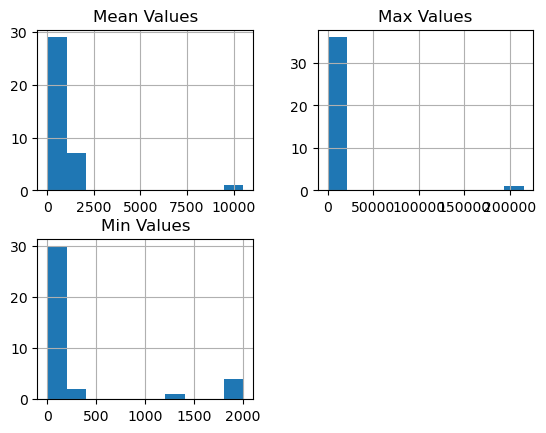

In [6]:
# Ensure the features (X) are defined from the dataset
X = dataset.iloc[:, :-1]  # All columns except the last one as features

# Visualizing the data
# Plot histograms for the mean, max, and min values of numeric features
numeric_data = X.select_dtypes(include=['int64', 'float64'])
mean_values = numeric_data.mean()
max_values = numeric_data.max()
min_values = numeric_data.min()

# Create a DataFrame for visualization
data_summary = pd.DataFrame({'Mean Values': mean_values, 'Max Values': max_values, 'Min Values': min_values})

# Plot histograms
data_summary.hist()


It's evident that most numerical features span a wide range of values, with some variables being several orders of magnitude larger than others. This indicates that data scaling will be necessary.

Additionally, when building a linear regression model using the original features, it's essential to compute a correlation matrix and remove features that are highly correlated. Failure to do so may result in a model that violates the assumptions of linear regression. When features are correlated, selecting which one to remove can be tricky and often requires domain expertise to ensure that the most relevant variables are retained. This process becomes cumbersome when dealing with a large number of features.

However, Principal Component Analysis (PCA) simplifies this task. The latent features generated by PCA are derived from the correlation matrix, ensuring they are uncorrelated by design. This removes the need for manually addressing correlation. While we will revisit the correlation matrix when constructing a supervised linear regression model, it is intentionally omitted here to demonstrate the power of PCA in dimensionality reduction.

Next, let’s explore the distribution of the response variable, Sell Price:

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: SalePrice
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB
None
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


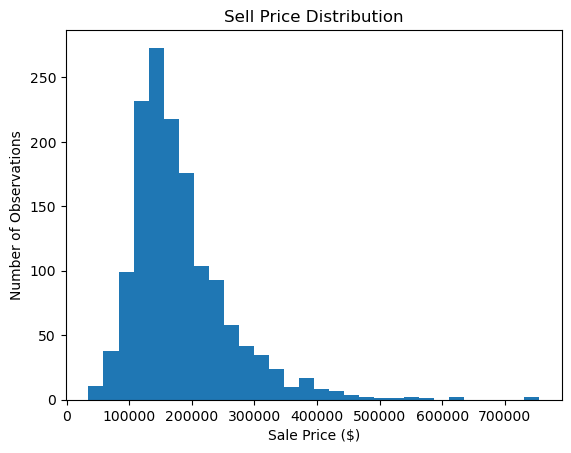

In [8]:
# Ensure the target variable (y) is defined from the dataset
y = dataset.iloc[:, -1]  # The last column is treated as the target variable

# Exploring the response variable: Sell Price
print(y.info())
print(y.describe())

# Visualizing the distribution of Sell Price
plt.hist(y, bins=30)
plt.xlabel('Sale Price ($)')
plt.ylabel('Number of Observations')
plt.title("Sell Price Distribution")
plt.show()


The response variable has no missing values, but there are a few outliers that we will remove during the data cleaning process.

## Data Preprocessing : Cleaning and Splitting
The first step involves cleaning the data. As observed earlier, several features contain missing values.

Some features clearly have missing data that need to be filled in. For instance, columns like LotFrontage, MasVnrType, MasVnrArea, and Electrical contain missing values that can be imputed with the most common value (mode) in each column.

However, after reviewing the dataset description, it's evident that many of the missing values in categorical variables actually indicate the absence of a particular feature. For example, an NA in the "GarageType" column suggests that the home has no garage. This kind of classification complicates things because it's unclear if a feature is truly absent or simply not recorded. To simplify this, we'll assume that in most cases, a missing value indicates the absence of a feature. Since PCA cannot handle missing values, we'll replace them with the string "FA" (Feature Absent) for object-type columns.

The only remaining float column with missing values is GarageYrBlt, which we'll impute using the column's mean.

Additionally, we'll drop the Id, MiscVal, and MiscFeature columns, as they do not contribute meaningfully to the analysis.

In [9]:
# Impute missing values with the most common values in specified columns
features_to_impute = ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical']
for feature in features_to_impute:
    most_common_value = X[feature].mode()[0]
    X[feature] = X[feature].fillna(most_common_value)

# Impute missing values in 'GarageYrBlt' with the most common value
most_common_garage_year = X['GarageYrBlt'].mean()
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(most_common_garage_year)

# Replace missing values with 'FA' (Feature Absent) in categorical columns
X.fillna('FA', inplace=True)

# Drop unnecessary columns
X = X.drop(columns=['Id', 'MiscVal', 'MiscFeature'])


Next, we need to ensure that the categorical variables are encoded properly for modeling. Ordinal encoding will be used for ordinal categories, while One-Hot Encoding will be applied to nominal categories. Since One-Hot Encoding generates multiple columns for each category, we'll first isolate the nominal features, apply encoding, and then merge them back with the original dataset.

In [10]:
# List of ordinal features
ordinal_features = ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 
                    'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                    'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 
                    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 
                    'Fence', 'SaleCondition', 'CentralAir']

# Apply ordinal encoding
encoder = LabelEncoder()
for feature in ordinal_features:
    X[feature] = encoder.fit_transform(X[feature])

# List of nominal features
nominal_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 
                    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                    'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 
                    'SaleType']

# Separate nominal features for one-hot encoding
OHC_features = X[nominal_features]
X = X.drop(columns=nominal_features)

# Apply one-hot encoding
OHC = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OHC_encoded = OHC.fit_transform(OHC_features)
OHC_feature_names = OHC.get_feature_names_out()

# Create DataFrame from encoded features
OHC_df = pd.DataFrame(OHC_encoded, columns=OHC_feature_names)

# Merge encoded features back into the original dataset
X = pd.concat([X, OHC_df], axis=1)


After applying one-hot encoding, the number of features has increased from the original 80 to 238. This expansion happens because each category in the nominal features is transformed into a new boolean feature representing each unique category in the original dataset.

Next, we’ll filter out any observations where the sale price falls more than three standard deviations away from the mean, as these are considered outliers.

In [11]:
# Combine features and target variable into one DataFrame
df = pd.concat([X, y], axis=1)

# Filter out outliers with sale prices above $420,000 (approximately 3 standard deviations from the mean)
df = df.loc[df['SalePrice'] <= 420000]

# Split back into features (X) and target (y)
X_clean = df.iloc[:, :-1]
y_clean = df.iloc[:, -1]


We will now standardize the data to ensure that no feature dominates due to its scale. Standardization is an essential step in PCA to ensure that each feature contributes equally to the analysis.

In [12]:
# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_clean)


Lastly, we will divide the data into training and test sets to evaluate the performance of our model.

In [13]:
# Split the standardized data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, y_clean, test_size=0.25, random_state=5)


### Data Preprocessing Part 2: Principal Component Analysis (PCA)

In this section, we will focus on performing Principal Component Analysis (PCA), which is a crucial aspect of the project. PCA will help create new latent features that summarize the dataset effectively. Although the `sklearn.decomposition` library handles most of the work, it's useful to understand the process happening behind the scenes. The following are the general steps involved:

1. **Covariance Matrix**: Calculate the covariance matrix to identify relationships between the features.
2. **Eigenvalues and Eigenvectors**: Compute these from the covariance matrix to determine the variance and directions of the principal components.
3. **Ordering Principal Components**: Eigenvalues are sorted in descending order to organize the components by the amount of variance they explain.
4. **Choosing Components**: Select the number of principal components to retain based on how much variance we aim to capture.
5. **Data Transformation**: Transform the original high-dimensional dataset into a lower-dimensional principal component space.

By using PCA, we ensure that the features included in the model are linearly independent, which eliminates the need to manually select which original features to keep. This can be extremely valuable for building predictive algorithms. However, a downside is that we lose some interpretability of the features. For example, understanding a 1-unit increase in lot size is intuitive, but interpreting a 1-unit change in a principal component that combines lot size and other variables like the number of bathrooms is much more abstract.

We will now create a PCA model using the original number of features and plot the explained variance as a function of the number of components.

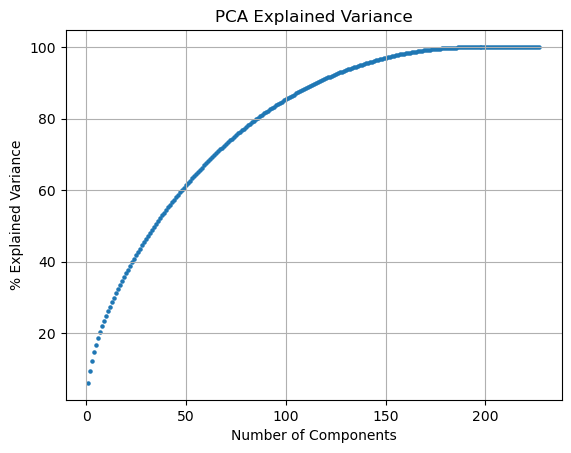

In [15]:
# Build the PCA model
pca = PCA()
X_pca = pca.fit_transform(X_train)
var_ratio = pca.explained_variance_ratio_

# Track number of components and percentage of explained variance
n_components = []
percent_explained_variance = []

# Calculate the cumulative explained variance for each component
for i in range(pca.n_components_):
    n_components.append(i + 1)
    percent_explained_variance.append(sum(var_ratio[:i+1]) * 100)

# Plot the explained variance by number of components
plt.scatter(n_components, percent_explained_variance, s=5)
plt.grid()
plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('% Explained Variance')
plt.show()


From this plot, we can observe that over 85% of the explained variance in the model is captured by just 100 components. Now, let's see how well these components perform in predictive models.



### PCA Regression

In this section, we will build regression models for principal components, ranging from 1 to 238 (the total number of components), and evaluate their performance. Since our primary focus is prediction rather than interpretability, we will use Root Mean Squared Error (RMSE) as the evaluation metric.


In [16]:

# Transform the original features into the principal component space
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize lists to store RMSE values for both train and test datasets
rmse_train = []
rmse_test = []

# Build regression models using different numbers of principal components and calculate RMSE
for i in range(pca.n_components_):
    X_train_n = X_train_pca[:, :i+1]  # Select the first 'n' principal components for training
    X_test_n = X_test_pca[:, :i+1]    # Select the same 'n' components for testing
    reg = LinearRegression().fit(X_train_n, y_train)
    
    # Predict on training data and calculate RMSE
    y_train_pred = reg.predict(X_train_n)
    rmse_train.append(np.sqrt(np.mean((y_train_pred - y_train) ** 2)))
    
    # Predict on test data and calculate RMSE
    y_test_pred = reg.predict(X_test_n)
    rmse_test.append(np.sqrt(np.mean((y_test_pred - y_test) ** 2)))

# Identify the number of components that minimizes RMSE on the test dataset
optimal_n = rmse_test.index(min(rmse_test)) + 1
min_rmse = min(rmse_test)

print(f'The model with the lowest RMSE on the test dataset uses {optimal_n} components, with an RMSE of: {min_rmse:.2f}')


The model with the lowest RMSE on the test dataset uses 130 components, with an RMSE of: 30630.76



The model with the lowest RMSE on the test dataset uses 130 components, achieving an RMSE of approximately 30,630.76. This indicates that the model performs best when using 130 principal components.

However, to better understand how the model's performance evolves as we increase the number of components, we can visualize the RMSE for both the training and test datasets across different numbers of components. Since overfitting can occur with a large number of components, making small changes harder to interpret, we will limit the plot to show the first 150 components.

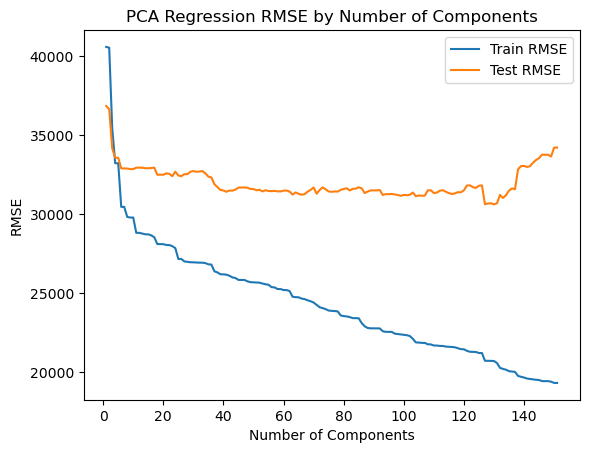

In [19]:
# Plot RMSE for both train and test datasets (up to 150 components)
plt.plot(n_components[:151], rmse_train[:151], label="Train RMSE")
plt.plot(n_components[:151], rmse_test[:151], label="Test RMSE")

# Set title and labels
plt.title("PCA Regression RMSE by Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("RMSE")
plt.legend()

# Display the plot
plt.show()


Although the model performs best with 130 components, the plot suggests that similar prediction results may be achievable with fewer components. Let’s examine the RMSE values for models with fewer components to see if this holds true.

In [20]:
# Inspect the RMSE of the first 10 models
rmse_test[:10]


[36860.964292912984,
 36656.69846732729,
 34182.00316875269,
 33580.83055599958,
 33580.37328750019,
 32907.48029234133,
 32908.08409404134,
 32897.95323190441,
 32862.8282352787,
 32862.95578698535]

While the RMSE for the model with 130 components is the lowest, using only 6 components gives an RMSE of 32,907.48, which is not as close to the optimal RMSE as initially thought. However, it is still a fairly reasonable performance, showing that fewer components may provide a simpler model with decent accuracy.

In conclusion, although the best model uses 130 components, a reduced model with fewer components—such as 6 or 10—may still offer a balance between simplicity and predictive power, depending on the application's tolerance for slightly higher error.

### Linear Regression with Original Features Using Backward Selection

In this section, we’ll build linear regression models using a supervised approach. Rather than including all available features, we will filter them based on their correlation with the sale price. Specifically, we will only consider features with a correlation coefficient of ≥ 0.4 or ≤ -0.4. Additionally, to avoid collinearity, we will examine the correlation matrix to identify highly correlated features that need to be removed. (Note: This step wasn't necessary during PCA since the principal components are constructed to be uncorrelated.)

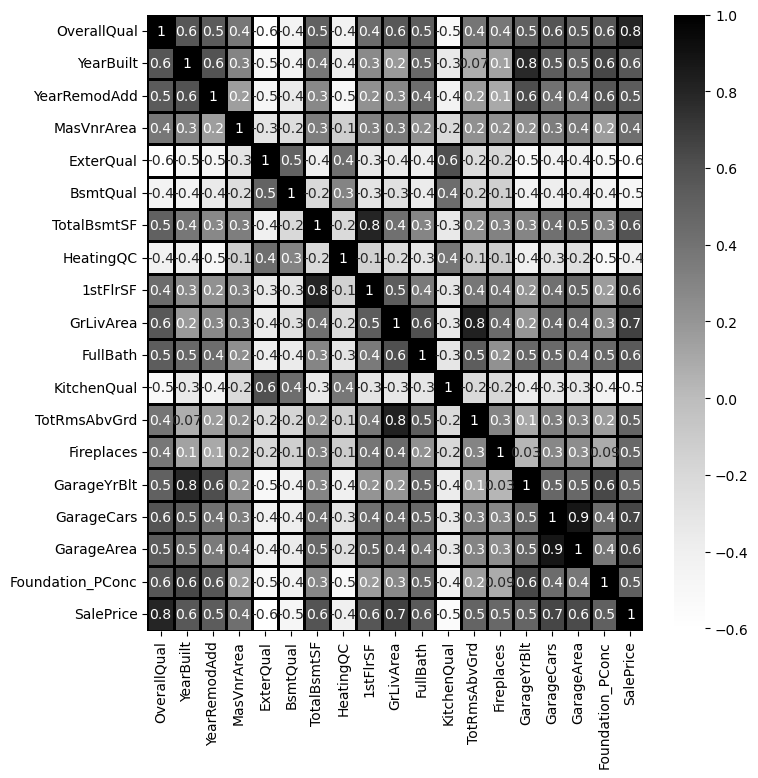

In [21]:

# Create a filtered DataFrame with top correlated features
feature_corr = df.corr().iloc[-1, :].reset_index()
top_features = feature_corr.query("SalePrice <= -0.4 or SalePrice >= 0.4")['index'].tolist()
df_top = df.filter(top_features)

# Plot the correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(df_top.corr(), cmap="Greys", linewidths=1, linecolor="black", annot=True, fmt=".1g")
plt.show()


The following features have a high correlation (|0.7| or higher) with other features and will be excluded:

- **GarageYrBlt**: Correlated with the year the house was built.
- **TotalBsmtSF**: Correlated with the 1st floor square footage.
- **TotRmsAbvGrd**: Correlated with the above-grade living area.
- **GarageArea**: Correlated with the number of cars that can fit into the garage.


In [22]:
# Remove highly correlated features
features_to_drop = ['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea']
df_top = df_top.drop(columns=features_to_drop)


After filtering out the collinear features, we will divide the data back into training and test sets. Unlike PCA, where features were sorted based on explained variance, here we need to carefully select the optimal combination of features. We’ll use backward selection as our feature selection method.


In [23]:
# Split the data into training and test sets
X = df_top.iloc[:, :-1]
y = df_top.iloc[:, -1]
X_std = pd.DataFrame(scaler.fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=5)

# Initialize lists to store results
col_names = X.columns.tolist()
n_features = []
rmse_train = []
rmse_test = []
feature_names = []

# Build linear regression models using backward selection
for i in range(len(X_train.columns)):
    # Set the number of features to use
    n = i + 1
    n_features.append(n)
    
    # Create a regression model with backward selection
    base_model = LinearRegression()
    model = RFE(base_model, n_features_to_select=n).fit(X_train, y_train)
    
    # Make predictions on training data
    y_train_pred = model.predict(X_train)
    rmse_train.append(np.sqrt(np.mean((y_train_pred - y_train) ** 2)))
    
    # Make predictions on test data
    y_test_pred = model.predict(X_test)
    rmse_test.append(np.sqrt(np.mean((y_test_pred - y_test) ** 2)))
    
    # Store the selected features
    selected_features = model.support_.tolist()
    selected_feature_list = [col_names[j] for j, selected in enumerate(selected_features) if selected]
    feature_names.append(selected_feature_list)

# Find and display the best performing model
optimal_n = rmse_test.index(min(rmse_test)) + 1
min_rmse = min(rmse_test)
print(f'The model with the lowest RMSE on the test dataset uses {optimal_n} features, with an RMSE of: {min_rmse:.2f}')
print('The features included in the best performing model were:', feature_names[rmse_test.index(min(rmse_test))])


The model with the lowest RMSE on the test dataset uses 7 features, with an RMSE of: 33128.35
The features included in the best performing model were: ['OverallQual', 'YearBuilt', '1stFlrSF', 'GrLivArea', 'KitchenQual', 'Fireplaces', 'GarageCars']


Finally, let’s visualize how RMSE changes as we include more features in the model.

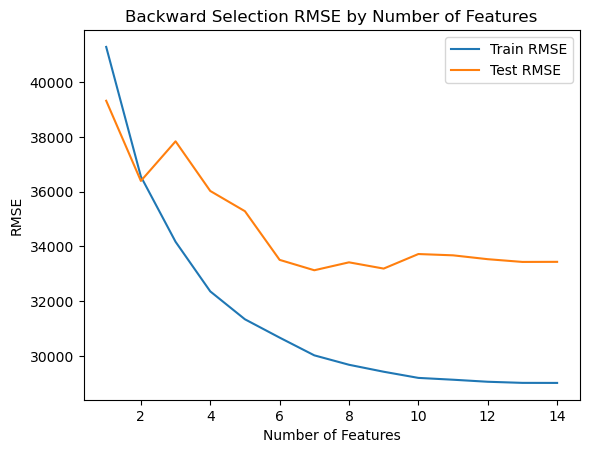

In [24]:
# Plot RMSE for both training and test sets
plt.plot(n_features, rmse_train, label="Train RMSE")
plt.plot(n_features, rmse_test, label="Test RMSE")

# Set plot title and labels
plt.title("Backward Selection RMSE by Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.legend()

# Display the plot
plt.show()


### Conclusion
The backward selection process reveals that the optimal model uses 7 features and achieves an RMSE of 33,128.35 on the test set. These features include key indicators such as the overall quality of the house, year built, and living area. The plot also helps to visualize how model performance improves as we increase the number of features, with diminishing returns after a certain point.


### Comparison of Results

Let’s reflect on what RMSE signifies in our models. Since the predicted values represent home prices, RMSE gives us an indication of how much the predicted prices tend to deviate from the actual prices, in terms of dollars. From the results, we can observe that the RMSE of the best-performing PCA model is lower than that of the best backward selection model by **$2,457**, or **7.4%**.

PCA provided a convenient, unsupervised way to construct a model while ensuring that the features were not correlated. However, the downside of PCA is that the latent features it generates are not easily interpretable. From the supervised model, we know that the original features with the greatest impact on housing prices are: **OverallQual**, **YearBuilt**, **1stFlrSF**, **GrLivArea**, **KitchenQual**, **Fireplaces**, and **GarageCars**. Unfortunately, we couldn’t directly derive these conclusions from the PCA model.

If the primary objective of the model is pure prediction, I would recommend using the PCA model. However, if explanation and interpretability are the main goals, a different approach would be more appropriate.

---

### Sources

- De Cock, D. (2011). *Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project.* Journal of Statistics Education, 19(3).

- [Kaggle: House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

- [Scikit-Learn: PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

- [Scikit-Learn: Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

- [Scikit-Learn: Recursive Feature Elimination (RFE)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)

- [Scikit-Learn: Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)

- [Towards Data Science: Principal Component Analysis](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c)
